In [264]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import itertools as it

In [265]:
training_data = np.loadtxt('../../NNQuST-master/benchmarks/c++/training_data.txt').astype(np.float32)
target_psi = np.loadtxt('../../NNQuST-master/benchmarks/c++/target_psi.txt').astype(np.float32)
target_psi = np.reshape(target_psi, (1024, 1))

In [266]:
class RBM:
    
    def __init__(self, train_data_file, num_hidden, num_visible, learning_rate, momentum, batch_size, weights=None, visible_bias=None, hidden_bias=None):
        
        # number of hidden units and visible units
        self.train_data_file = train_data_file
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size # mini batch size for Stoch. grad. desc.
        self.momentum = momentum   
        
        # initialize weights, visible bias and hidden bias
        self.weights = tf.Variable(tf.random_normal(shape=(self.num_visible, self.num_hidden), mean = 0.0, 
                                                    stddev = 0.1, dtype = tf.float32, seed = None, name = None), tf.float32) # rows = num_hid, cols = num_vis
        
        #self.weights = tf.get_variable('weights', shape = (self.num_visible, self.num_hidden), initializer = tf.random_normal_initializer)
        
        self.hidden_bias = tf.Variable(tf.zeros(shape=(self.num_hidden,1)), tf.float32)
        self.visible_bias = tf.Variable(tf.zeros(shape=(self.num_visible,1)), tf.float32)
        
        # velocities for momentum
        #self.weights_vel = tf.Variable(tf.zeros_like(self.weights), dtype = tf.float32)
        #self.visible_bias_vel = tf.Variable(tf.zeros_like(self.visible_bias), dtype = tf.float32)
        #self.hidden_bias_vel = tf.Variable(tf.zeros_like(self.hidden_bias), dtype = tf.float32)

        self._all_hidden_states = None
        self.max_feasible_for_log_pf = 24 
    
    @property
    def all_hidden_states(self):
        if self._all_hidden_states is None:
            assert self.num_hidden <= self.max_feasible_for_log_pf, \
                'cannot generate all hidden states for num_hidden > {}'.format(self.max_feasible_for_log_pf)
            self._all_hidden_states = np.array(list(it.product([0, 1], repeat=self.num_hidden)), dtype=np.float32)
        return self._all_hidden_states
    

    def free_energy(self, visible_samples):
        free_energy_  = tf.matmul(visible_samples, self.visible_bias)
        temp          = tf.reduce_sum(tf.nn.softplus(tf.matmul(visible_samples, self.weights) + tf.transpose(self.hidden_bias)),1)
        free_energy_ += tf.reshape(temp, shape = (visible_samples.shape[0], 1))
        
        return free_energy_
    
    # calculate NLL
    def negative_log_likelihood(self, visible_samples, log_Z):
        free_energy_  = tf.matmul(visible_samples, self.visible_bias)
        free_energy_ += tf.reduce_sum(tf.nn.softplus(tf.matmul(visible_samples, self.weights) 
                                                    + tf.transpose(self.hidden_bias)),1)
        
        return -tf.reduce_mean(free_energy_ - log_Z)      
    
    # juan's code for exact logZ
    def exact_log_partition_function(self):
        with tf.name_scope('exact_log_Z'):
            # Define the exponent: H*b + sum(softplus(1 + exp(a + w*H.T)))
            first_term = tf.matmul(self.all_hidden_states, self.hidden_bias, name='first_term')
            with tf.name_scope('second_term'):
                second_term = tf.matmul(self.weights, self.all_hidden_states, transpose_b=True)
                second_term = tf.nn.softplus(tf.add(self.visible_bias, second_term))
                second_term = tf.transpose(tf.reduce_sum(second_term, reduction_indices=[0], keep_dims=True))
            exponent = tf.cast(first_term + second_term, dtype=tf.float32, name='exponent')
            #exponent_mean = tf.reduce_mean(exponent)
            exponent_mean = tf.reduce_max(exponent)

            return tf.log(tf.reduce_sum(tf.exp(exponent - exponent_mean))) + exponent_mean
    
    def exact_Z(self):
        return tf.to_float(tf.exp(self.exact_log_partition_function()))
    
    def energy(self, hidden_samples, visible_samples):
        return  -tf.matmul(visible_samples, self.visible_bias) \
                - tf.matul(hidden_samples, self.hidden_bias) \
                - tf.reduce_sum(tf.matmul(visible_samples, self.weights) * hidden_samples, 1)

    def prob_hidden_given_visible(self, visible_samples):
        # make sure doing right multiplcation here
        arg = tf.matmul(visible_samples, self.weights) + tf.transpose(self.hidden_bias)
        return tf.nn.sigmoid(arg)

    def prob_visible_given_hidden(self, hidden_samples):
        # make sure doing right multiplcation here
        arg = tf.matmul(hidden_samples, self.weights, transpose_b=True) + tf.transpose(self.visible_bias)
        return tf.nn.sigmoid(arg)

    def sample_hidden_given_visible(self,visible_samples):
        b = tf.shape(visible_samples)[0] # the number of visible samples
        m = self.num_hidden
        samples = self.sample(self.prob_hidden_given_visible(visible_samples), b, m)
        return samples

    def sample_visible_given_hidden(self,hidden_samples):
        b = tf.shape(hidden_samples)[0] # the number of hidden samples
        n = self.num_visible
        samples = self.sample(self.prob_visible_given_hidden(hidden_samples), b, n)
        return samples

    def gibbs_sampling(self, num_iters, v0_samples): # initialize v from a training sample batch, v0 -- matrix of shape 
                                                     # (batch_size=num_rows, shape(training_sata_file)[1])=num_cols)
        h0_samples = self.sample_hidden_given_visible(v0_samples)
        v_samples, h_samples = v0_samples, h0_samples 

        for i in range(num_iters):
            v_samples = self.sample_visible_given_hidden(h_samples)
            h_samples = self.sample_hidden_given_visible(v_samples)

        # spit out original visible and hidden samples, the reconstructed sample and the prob_h_given_v
        return v0_samples, h0_samples, v_samples, self.prob_hidden_given_visible(v_samples)
    
    # gradient of neg. log liklihood
    def grad_NLL_one_batch(self, batch, num_gibbs_iters):     
    
        #w_grad  = tf.zeros_like(self.weights)
        #vb_grad = tf.zeros_like(self.visible_bias) # vb_grad = (num_vis, 1). hb_grad = (num_hid, 1)
        #hb_grad = tf.zeros_like(self.hidden_bias)

        v0, h0, vk, prob_h = self.gibbs_sampling(num_gibbs_iters, batch)

        # v0 and vk (batch_size, n_vis)
        # h0 and prob_h (batch_size, n_hidden)

        w_grad  = tf.matmul(tf.transpose(v0), h0) - tf.matmul(tf.transpose(vk), prob_h)
        vb_grad = tf.reshape(tf.reduce_mean(v0 - vk, 0), shape = (self.num_visible,1))
        hb_grad = tf.reshape(tf.reduce_mean(h0 - prob_h, 0), shape = (self.num_hidden,1))
        
        w_grad  /= tf.to_float(tf.shape(batch)[0])
        #vb_grad /= tf.to_float(tf.shape(batch)[0])
        #hb_grad /= tf.to_float(tf.shape(batch)[0])
        
        return w_grad, vb_grad, hb_grad

    def probability(self, visible_samples, Z):
        free_energy_ = self.free_energy(visible_samples)
        
        return tf.exp(free_energy_)/Z

    def sqrt_probability_vector(self, visible_samples, Z):
        return tf.sqrt(self.probability(visible_samples, Z))
    
    def overlap(self, target_wavefunction, visible_space, Z):
        overlap_  = tf.matmul(tf.transpose(target_wavefunction), self.sqrt_probability_vector(visible_space, Z))
        #overlap_ /= tf.sqrt(tf.exp(log_Z))
        return overlap_

    def get_batch(self, index):
        batch_start = index*self.batch_size
        batch_end   = batch_start + self.batch_size 
        batch       = self.train_data_file[batch_start:batch_end,:]
        return batch
    
    def learn(self, num_gibbs_iters, batch): # learning algorithm for 1 batch      
        # calculate gradients for a batch
        weight_grad, visible_bias_grad, hidden_bias_grad = self.grad_NLL_one_batch(batch, num_gibbs_iters)

        # update velocities for momentum
        #new_weights_vel      = self.momentum*self.weights_vel      + self.learning_rate*weight_grad
        #new_visible_bias_vel = self.momentum*self.visible_bias_vel + self.learning_rate*visible_bias_grad
        #new_hidden_bias_vel  = self.momentum*self.hidden_bias_vel  + self.learning_rate*hidden_bias_grad     

        # update weights and biases 
        update_weights        = tf.assign(self.weights, self.weights + self.learning_rate*weight_grad)
        update_visible_biases = tf.assign(self.visible_bias, self.visible_bias + self.learning_rate*visible_bias_grad)
        update_hidden_biases  = tf.assign(self.hidden_bias, self.hidden_bias + self.learning_rate*hidden_bias_grad)            

        #update_weights        = tf.assign(self.weights, self.weights + new_weights_vel)
        #update_visible_biases = tf.assign(self.visible_bias, self.visible_bias + new_visible_bias_vel)
        #update_hidden_biases  = tf.assign(self.hidden_bias, self.hidden_bias + new_hidden_bias_vel)

        # update velocities
        #update_weights_vel      = tf.assign(self.weights_vel, new_weights_vel)
        #update_visible_bias_vel = tf.assign(self.visible_bias_vel, new_visible_bias_vel)
        #update_hidden_bias_vel  = tf.assign(self.hidden_bias_vel, new_hidden_bias_vel)

        # return [update_weights, update_visible_biases, update_hidden_biases, 
        # update_weights_vel, update_visible_bias_vel, update_hidden_bias_vel]
        
        return [update_weights, update_visible_biases, update_hidden_biases]

    @staticmethod
    def sample(probs, m, n):
        return tf.where(
            tf.less(tf.random_uniform(shape=(m,n)), probs),
            tf.ones(shape=(m,n)),
            tf.zeros(shape=(m,n))
        )

    @staticmethod
    def generate_all_possible_visibles(Nspins): # generate all configurations of 0 and 1 for 10 spins
        vis_space = np.zeros((2**Nspins, Nspins)).astype(np.float32)

        for i in range(2**Nspins): # rows  
            temp = i
            for j in range(Nspins): # columns
                temp, remainder = divmod(temp, 2)
                vis_space[i, j] = remainder 

        return vis_space

In [269]:
class Placeholders(object):
    pass

def data_randomizer(data_file):
    shuffled_data = tf.random_shuffle(data_file)
    return shuffled_data

placeholders = Placeholders()

def train(training_data, num_epochs):
    weights=None
    visible_bias=None
    hidden_bias=None
    
    num_hidden      = 10
    learning_rate   = 0.1
    num_visible     = training_data.shape[1]
    momentum        = 0.0
    batch_size      = 100
    num_batches     = int(training_data.shape[0]/batch_size)
    num_gibbs_iters = 10
    epoch_list      = []
    rbm             = RBM(training_data, num_hidden, num_visible, learning_rate, momentum, batch_size, 
                          weights = weights, visible_bias = visible_bias, hidden_bias = hidden_bias)
    
    placeholders.visible_samples     = tf.placeholder(tf.float32, shape=(batch_size, num_visible))
    placeholders.visible_space       = tf.placeholder(tf.float32, shape=(1024, num_visible))
    placeholders.target_wavefunction = tf.placeholder(tf.float32, shape=(1024, 1))
    
    vis_space         = rbm.generate_all_possible_visibles(num_visible)
    logZ              = rbm.exact_log_partition_function()
    placeholders.logZ = tf.placeholder(tf.float32)
    NLL               = rbm.negative_log_likelihood(placeholders.visible_samples, placeholders.logZ)
    Z                 = rbm.exact_Z()
    placeholders.Z    = tf.placeholder(tf.float32)
    OVERLAP           = rbm.overlap(placeholders.target_wavefunction, placeholders.visible_space, placeholders.Z)
    #prob_vec          = rbm.probability(placeholders.visible_samples, placeholders.Z)
    #free              = rbm.free_energy(placeholders.visible_samples)
    
    step = rbm.learn(num_gibbs_iters, placeholders.visible_samples)
        
    with tf.Session() as sess:
        NLL_list = [] # will hold NLLs after each epoch
        OVERLAP_list = []
        cost = [] # will hold NLLs for a batch during an epoch
        batch_count = 0
        epoch = 0
        init = tf.global_variables_initializer()
        sess.run(init)
        
        for i in range(num_epochs*num_batches):
            if batch_size*batch_count + batch_size >= training_data.shape[0]: # if we have gone through the whole data file:
                epoch_list.append(epoch)
                NLL_list.append(np.mean(cost))
                #f = sess.run(free, feed_dict = {placeholders.visible_samples: vis_space})
                #print f
                z = sess.run(Z)
                #print z
                overlap = sess.run(OVERLAP, feed_dict = {placeholders.target_wavefunction: target_psi, 
                                                         placeholders.visible_space: vis_space, 
                                                         placeholders.Z: z})
                print overlap.shape
                OVERLAP_list.append(overlap)
                print 'Weights: >>> \n',sess.run(rbm.weights)
                print 'Epoch: %d, NLL >>> %g, OVERLAP >>> %g' % (epoch, np.mean(cost), overlap)
                cost   = [] # reset this list
                epoch += 1
                training_data = data_randomizer(training_data) # shuffle data again
                batch_count = 0
            lz = sess.run(logZ)
            batch_count += 1
            new_batch = rbm.get_batch(batch_count)            
            sess.run(step, feed_dict = {placeholders.visible_samples: new_batch})
            nll = sess.run(NLL, feed_dict = {placeholders.visible_samples: new_batch, placeholders.logZ: lz})
            #print 'nll >>>', nll,'\t logZ >>>,',lz
            cost.append(nll)
            
    return NLL_list, OVERLAP_list, epoch_list

In [270]:
NLL_list, OVERLAP_list, epoch_list = train(training_data, 100)
#print OVERLAP_list
#print overlap_list

(1, 1)
Weights: >>> 
[[-0.33553934  0.34734702 -0.08900087 -0.17169909 -0.2571081  -0.14933921
  -0.21100587  0.25382504 -0.21754672 -0.23502637]
 [-0.32259282  0.30901703 -0.1154854  -0.30987608 -0.14118415 -0.20598382
  -0.30241868  0.271288   -0.1703518  -0.32777253]
 [-0.30710408  0.23659123 -0.0678162  -0.24197444 -0.15893963 -0.06033343
  -0.26612946  0.2947919  -0.21651214 -0.40734598]
 [-0.1989789   0.3791595  -0.05692874 -0.3289003  -0.0693337  -0.1378701
  -0.21307175  0.14189568 -0.24576095 -0.4649683 ]
 [-0.29132178  0.41302773  0.01524486 -0.34301558 -0.11841169 -0.05108346
  -0.2939015   0.2634294  -0.33509514 -0.31738424]
 [-0.28134793  0.3657032  -0.05903668 -0.33410013 -0.13675442 -0.11055577
  -0.20592055  0.25471166 -0.20940323 -0.4442076 ]
 [-0.1738251   0.39709708  0.0241858  -0.26547387 -0.15797162 -0.1117589
  -0.3179491   0.22771455 -0.24593866 -0.37368804]
 [-0.31766337  0.25513962 -0.01798368 -0.26918206 -0.24246855 -0.09728971
  -0.18593386  0.36206844 -0.174

(1, 1)
Weights: >>> 
[[-0.67006755  0.81840265 -0.5261869  -0.41576436 -0.6480281  -0.50832754
  -0.5648063   0.7979633  -0.5145939  -0.42984244]
 [-0.6372461   0.66735023 -0.52553344 -0.52852356 -0.5238708  -0.50318205
  -0.5953528   0.8287709  -0.4562123  -0.4986223 ]
 [-0.5622657   0.67164385 -0.49630916 -0.5145573  -0.47931924 -0.4629729
  -0.5655986   0.7887627  -0.513981   -0.60025936]
 [-0.46432182  0.7955832  -0.46428028 -0.5765282  -0.34228352 -0.44254702
  -0.5047463   0.63008314 -0.5922931  -0.6552105 ]
 [-0.46309355  0.82871574 -0.38805756 -0.5741657  -0.36807433 -0.39596358
  -0.54246074  0.6375217  -0.644509   -0.6733703 ]
 [-0.46391895  0.8445033  -0.39405042 -0.6023214  -0.45986438 -0.44449583
  -0.5165718   0.7396414  -0.5157574  -0.77297515]
 [-0.4673486   0.87143636 -0.29990533 -0.49567643 -0.5011372  -0.40614584
  -0.5403889   0.7459152  -0.5074014  -0.6463887 ]
 [-0.5695942   0.6820006  -0.35183567 -0.53678906 -0.5707484  -0.42696452
  -0.49241665  0.85989267 -0.47

(1, 1)
Weights: >>> 
[[-0.9217139   0.7053352  -0.61703897 -0.31852996 -0.7586306  -0.6269803
  -0.5033089   0.94269025 -0.29032028 -0.18574856]
 [-0.8356228   0.6121112  -0.64107645 -0.3418779  -0.57566607 -0.6122238
  -0.5718562   0.95822674 -0.28455395 -0.3409057 ]
 [-0.61470646  0.6692727  -0.50528365 -0.42486802 -0.43143225 -0.47176376
  -0.5643292   0.8241607  -0.4746072  -0.61298263]
 [-0.37862295  0.89558977 -0.40987268 -0.55514455 -0.15269239 -0.31457153
  -0.48591912  0.59102124 -0.67798615 -0.83110064]
 [-0.29655364  1.0045578  -0.28118914 -0.61526465 -0.16443178 -0.19954744
  -0.5213197   0.5633742  -0.7539374  -0.95627594]
 [-0.3095336   0.9523332  -0.22631545 -0.6349584  -0.31666094 -0.2848352
  -0.5180117   0.6052422  -0.6560997  -1.033563  ]
 [-0.34541562  0.91922516 -0.14237732 -0.59179765 -0.43697736 -0.3123083
  -0.5098283   0.74616086 -0.51952577 -0.86491877]
 [-0.57948434  0.7587275  -0.16611896 -0.5620111  -0.6018285  -0.4634682
  -0.4496505   0.9116764  -0.442009

(1, 1)
Weights: >>> 
[[-1.2538431   0.63537467 -0.84245676 -0.21407878 -0.9334135  -0.82863647
  -0.5125982   1.1145095  -0.06438962  0.09189197]
 [-1.0145723   0.5508979  -0.93817925 -0.24693204 -0.610946   -0.6810211
  -0.600208    1.0986414  -0.1431107  -0.13984816]
 [-0.6162374   0.70891166 -0.77955455 -0.36285514 -0.25268468 -0.34623593
  -0.5790226   0.7790544  -0.5312187  -0.5481271 ]
 [-0.2757112   0.9986173  -0.5697591  -0.6270738   0.03263349 -0.10023587
  -0.5421956   0.4548173  -0.920722   -1.0668937 ]
 [-0.0455659   1.220376   -0.26057902 -0.7424228   0.08979201  0.05284779
  -0.546175    0.4381262  -1.025622   -1.3605882 ]
 [-0.04479673  1.1768018  -0.07919265 -0.82826257 -0.20392925  0.02024418
  -0.43855777  0.51298773 -0.9089244  -1.4170932 ]
 [-0.11315847  1.0319135   0.12142593 -0.87989295 -0.422455   -0.08797316
  -0.3588094   0.7106807  -0.6345395  -1.1231252 ]
 [-0.4751725   0.7247543   0.11308075 -0.83648485 -0.734685   -0.39861763
  -0.3146454   0.9016303  -0.41

(1, 1)
Weights: >>> 
[[-1.531706    0.6064012  -1.0417688   0.02350544 -0.8954503  -1.0245006
  -0.6400661   1.2451022   0.04189406  0.322082  ]
 [-1.2080829   0.53973573 -1.4211568   0.1436459  -0.34461936 -0.7532173
  -0.8457418   1.1417423  -0.19153404  0.02323801]
 [-0.6827752   0.77111816 -1.3048346  -0.05704395  0.08434966 -0.37397578
  -0.8912769   0.7018711  -0.7576089  -0.5200775 ]
 [-0.23655306  1.1332799  -0.9457962  -0.31753573  0.33842513  0.03431033
  -0.74379194  0.30181706 -1.2075303  -1.1173666 ]
 [ 0.05041636  1.4271241  -0.39581022 -0.63863415  0.36153594  0.17464769
  -0.7098989   0.21387728 -1.4311385  -1.5871872 ]
 [ 0.1596213   1.3469235   0.23403254 -1.038575   -0.18659462  0.10299563
  -0.50134444  0.3148957  -1.1064092  -1.6738306 ]
 [ 0.00583615  1.0438217   0.6445824  -1.2246479  -0.69128054 -0.03658283
  -0.4002214   0.672984   -0.59453565 -1.2978132 ]
 [-0.37885582  0.7012814   0.68104684 -1.244136   -1.0908551  -0.40880394
  -0.3102331   0.9089971  -0.316

(1, 1)
Weights: >>> 
[[-1.6498678   0.6251832  -1.1569628   0.16070434 -0.76152486 -1.0951558
  -0.6745982   1.2078274   0.12105723  0.33207512]
 [-1.3499522   0.60300815 -1.7983402   0.30968925 -0.10602588 -0.8421812
  -1.0209416   1.1429964  -0.23815736 -0.00183482]
 [-0.71673     0.82008654 -1.7040453   0.1262208   0.35022148 -0.44353828
  -1.0877887   0.7505686  -0.91343296 -0.46676648]
 [-0.25925675  1.199741   -1.2740496  -0.09997927  0.5011518  -0.07453234
  -0.9628832   0.24192625 -1.4269521  -1.1369852 ]
 [ 0.06858302  1.536319   -0.514105   -0.5169978   0.43785498  0.1352229
  -0.70867276  0.15237182 -1.581857   -1.6530124 ]
 [ 0.200672    1.3814075   0.3109857  -1.0956777  -0.19255708  0.0847543
  -0.41663456  0.24850592 -1.0316588  -1.8262953 ]
 [ 0.05804183  1.0563142   0.8548596  -1.5313891  -0.8648096  -0.03511159
  -0.24826023  0.6618206  -0.5018454  -1.4241699 ]
 [-0.3368898   0.7228213   0.9164562  -1.6392688  -1.3839957  -0.47871432
  -0.24542236  0.951929   -0.16519

(1, 1)
Weights: >>> 
[[-1.7982502   0.6613794  -1.123711    0.19369678 -0.7680883  -1.1002346
  -0.70918876  1.1568025   0.14714186  0.28603292]
 [-1.4008757   0.58458847 -1.9038013   0.2949089  -0.03336039 -0.82398254
  -1.0770282   1.111167   -0.20138536  0.05989771]
 [-0.7009768   0.8214538  -1.8183708   0.10502769  0.35105824 -0.4575643
  -1.2538587   0.7537014  -0.97856826 -0.41869208]
 [-0.18018809  1.2552094  -1.4090297  -0.02317277  0.47398448 -0.05991243
  -1.0317253   0.2780498  -1.5618385  -1.0112255 ]
 [ 0.07081795  1.5236564  -0.5138319  -0.43556592  0.42346996  0.19343619
  -0.74148107  0.13136475 -1.6743939  -1.6696205 ]
 [ 0.18188837  1.4186419   0.33238667 -1.1294296  -0.26614264  0.08914001
  -0.43821695  0.2666823  -0.9696936  -1.9684106 ]
 [ 0.15347925  1.0550276   0.88774747 -1.6676735  -0.90976465  0.01478797
  -0.25787717  0.6683303  -0.46907416 -1.5659748 ]
 [-0.21228597  0.76441     0.96243906 -1.8111117  -1.5124415  -0.45629874
  -0.29973975  0.9910764  -0.096

(1, 1)
Weights: >>> 
[[-1.9865507   0.6530956  -1.0707476   0.14332014 -0.7253896  -1.0972964
  -0.6720518   1.1871498   0.1768463   0.24133955]
 [-1.5352625   0.600602   -1.9174609   0.19747424  0.05112132 -0.80214983
  -1.1270701   1.1192969  -0.1168049   0.03398573]
 [-0.6362381   0.7855081  -1.874984    0.04811615  0.4189596  -0.39488438
  -1.3106788   0.79353505 -1.001844   -0.33821532]
 [-0.22399406  1.2290117  -1.4031531  -0.03522091  0.50327396  0.0225065
  -1.0385464   0.28787306 -1.7457327  -0.9751514 ]
 [-0.00632083  1.5425603  -0.4261983  -0.3593125   0.4418169   0.2318283
  -0.71247524  0.12244327 -1.7157269  -1.6477026 ]
 [ 0.07924744  1.3712208   0.3989394  -1.1091305  -0.19150089  0.12304562
  -0.37086868  0.24522635 -0.8979774  -2.092094  ]
 [ 0.10675538  1.0490003   0.8589629  -1.73546    -0.8891713   0.07639945
  -0.343244    0.6782111  -0.40403485 -1.7227857 ]
 [-0.27797958  0.77810675  0.9840661  -1.9371195  -1.532021   -0.3416092
  -0.3729211   1.0333233  -0.03553

(1, 1)
Weights: >>> 
[[-2.033779    0.7115284  -1.0530411   0.2758071  -0.6895986  -1.0821837
  -0.60374224  1.0692087   0.240362    0.19959097]
 [-1.4924605   0.59751236 -2.012616    0.21282454  0.07896731 -0.8777216
  -1.1818917   1.0429251  -0.02166937  0.02011773]
 [-0.55682474  0.8292077  -1.9333569   0.01333828  0.4301151  -0.4740698
  -1.3655457   0.79802316 -0.99692076 -0.3125048 ]
 [-0.15333992  1.296452   -1.4141537   0.00734253  0.44544366 -0.07694407
  -1.0556002   0.20618483 -1.8953607  -0.9073972 ]
 [-0.05473496  1.6187818  -0.43068483 -0.20450196  0.40343937  0.10602555
  -0.6917474   0.05270274 -1.7579426  -1.6154386 ]
 [ 0.01185076  1.4207565   0.43669358 -1.0672573  -0.13031922  0.00574913
  -0.36671904  0.1900257  -0.8395673  -2.2265453 ]
 [ 0.17827103  1.0997703   0.8307227  -1.7826474  -0.850674    0.0077488
  -0.35436255  0.6877706  -0.2900575  -1.8135879 ]
 [-0.16791834  0.7691434   0.92109585 -1.9468797  -1.5670141  -0.39937833
  -0.3932379   0.99027157  0.01425

(1, 1)
Weights: >>> 
[[-2.1898334   0.7399441  -0.98126036  0.29795635 -0.6341909  -1.0471019
  -0.52490866  1.1207118   0.28734615  0.1486593 ]
 [-1.506857    0.5783489  -1.9999548   0.09021789  0.17660682 -0.8464548
  -1.1898788   1.158543    0.1693231  -0.0531266 ]
 [-0.48173594  0.7557522  -1.9974692  -0.12130882  0.4553957  -0.42367834
  -1.3747054   0.9103748  -1.0478684  -0.23416771]
 [-0.09096997  1.2301476  -1.4036951  -0.02580106  0.42319638 -0.04743508
  -1.0328258   0.28381604 -2.0387897  -0.83118945]
 [-0.05481013  1.5977631  -0.34743187 -0.22196804  0.38857645  0.15655735
  -0.63514215  0.10321761 -1.794506   -1.5957799 ]
 [-0.08436989  1.4342166   0.44931495 -1.0779533  -0.04384815  0.05499767
  -0.34058133  0.22786453 -0.78952193 -2.304776  ]
 [ 0.1764698   1.0933163   0.80112743 -1.8950624  -0.7330854   0.04485939
  -0.35781097  0.66352063 -0.2482934  -1.8819642 ]
 [-0.0685105   0.7545922   0.8283049  -2.073752   -1.5073193  -0.33090636
  -0.465335    1.022763    0.024

(1, 1)
Weights: >>> 
[[-2.3452985   0.72116536 -0.9482167   0.40751448 -0.6602842  -1.0751863
  -0.53162843  1.0311973   0.3007702   0.040901  ]
 [-1.5718627   0.49825495 -1.9943373   0.09298962  0.23546043 -0.85246235
  -1.2026622   1.1499345   0.25594917 -0.13151877]
 [-0.4436561   0.6527979  -2.093454   -0.12674603  0.41988328 -0.40663308
  -1.4439211   0.89601016 -1.0775819  -0.24337831]
 [-0.10341571  1.2383742  -1.391234    0.0703801   0.34664682  0.0113609
  -1.0597748   0.30415243 -2.2133124  -0.7164222 ]
 [-0.15083906  1.5855702  -0.30859563 -0.07946563  0.25379902  0.1436186
  -0.63617337  0.01729227 -1.9381199  -1.5721066 ]
 [-0.196873    1.3992316   0.46105096 -0.90784025 -0.05181136  0.12696742
  -0.35523176  0.20586123 -0.7421066  -2.3942974 ]
 [ 0.13856484  1.0754095   0.78124976 -1.9069005  -0.6742969   0.13807179
  -0.39819837  0.7349416  -0.11494896 -1.996987  ]
 [-0.02498623  0.7523249   0.8258331  -2.1297078  -1.4914443  -0.2575031
  -0.54144233  1.0468199   0.04958

(1, 1)
Weights: >>> 
[[-2.4640555   0.7504882  -0.93669295  0.48854536 -0.73106474 -0.93115765
  -0.47837636  0.9854666   0.37268296 -0.05006165]
 [-1.5723009   0.50304925 -2.1185496   0.09151975  0.19085468 -0.74440986
  -1.2201837   1.1890849   0.34029657 -0.1786783 ]
 [-0.40302756  0.69734955 -2.124885   -0.17663488  0.373751   -0.32983932
  -1.5170894   0.9729399  -1.0072424  -0.15955265]
 [-0.12710205  1.2862502  -1.3728796   0.15756123  0.21600804  0.03822716
  -1.1005371   0.3432198  -2.3654788  -0.60912853]
 [-0.16363496  1.6966733  -0.21283251  0.02821332  0.14850084  0.21299738
  -0.57442087  0.06007529 -2.0326316  -1.6204599 ]
 [-0.26333603  1.3881347   0.49096453 -0.8438856  -0.1033525   0.13317138
  -0.2866671   0.22328445 -0.65922385 -2.5455716 ]
 [ 0.13661574  1.0827506   0.70069003 -1.917948   -0.6546491   0.19927286
  -0.42891002  0.77429247 -0.04542996 -2.0703287 ]
 [ 0.06581006  0.75355643  0.7325708  -2.1607227  -1.5548339  -0.2338805
  -0.60080343  1.0595654   0.06

(1, 1)
Weights: >>> 
[[-2.5460427   0.8509991  -0.89342004  0.44630712 -0.6354707  -0.9722471
  -0.4874566   0.9484419   0.44367945 -0.12569517]
 [-1.5258114   0.48740122 -2.2501767   0.03924096  0.3097662  -0.78571445
  -1.3352945   1.1378721   0.4867763  -0.23264374]
 [-0.25425044  0.6088658  -2.3118215  -0.21347456  0.3980159  -0.38019958
  -1.6236191   0.9609263  -1.0602343  -0.08845181]
 [-0.08719413  1.2975979  -1.3398732   0.13657214  0.20027488  0.00279113
  -1.1352557   0.38933787 -2.4452107  -0.52213365]
 [-0.18098575  1.7497319  -0.19889313  0.02474968  0.14668462  0.17519188
  -0.49359044  0.06425795 -2.1020505  -1.6843538 ]
 [-0.30106917  1.4351882   0.453398   -0.8907471   0.00720662  0.09757981
  -0.2675995   0.21497983 -0.6232281  -2.695725  ]
 [ 0.18203141  1.0494146   0.6129531  -2.0755718  -0.49646726  0.16914491
  -0.45107785  0.7216667   0.12485984 -2.0796149 ]
 [ 0.1692626   0.7316139   0.58595574 -2.2910404  -1.5099026  -0.19387822
  -0.6588406   1.0670124   0.12

(1, 1)
Weights: >>> 
[[-2.6570892e+00  8.5466862e-01 -9.0283281e-01  4.4490737e-01
  -5.7273245e-01 -1.0056330e+00 -4.6484959e-01  9.3429118e-01
   4.5137447e-01 -1.1759868e-01]
 [-1.6217686e+00  4.5157140e-01 -2.2982731e+00 -1.3399567e-02
   3.8887513e-01 -8.2062876e-01 -1.3342021e+00  1.1704915e+00
   5.5383909e-01 -2.6100343e-01]
 [-1.4998947e-01  6.1056298e-01 -2.3948102e+00 -2.4458572e-01
   4.3741074e-01 -3.4418941e-01 -1.6356351e+00  9.9316794e-01
  -1.1072353e+00 -1.8749855e-02]
 [-5.6460526e-02  1.3330606e+00 -1.2823972e+00  1.6400373e-01
   2.1325746e-01  1.6941228e-03 -1.1235044e+00  3.5284039e-01
  -2.6490672e+00 -4.3253663e-01]
 [-2.3111396e-01  1.7729659e+00 -1.3618934e-01  9.0864815e-02
   8.3624527e-02  1.2359990e-01 -4.7673413e-01  4.3710709e-02
  -2.2267542e+00 -1.7057102e+00]
 [-3.4345281e-01  1.4531561e+00  4.3248495e-01 -8.4987032e-01
   2.9418016e-02  4.0928438e-02 -3.0179849e-01  1.9414285e-01
  -5.7866013e-01 -2.6972997e+00]
 [ 1.6900091e-01  1.0821413e+00  5.84

(1, 1)
Weights: >>> 
[[-2.7743018   0.87301266 -0.88577056  0.4610853  -0.49707198 -0.97753316
  -0.48081908  0.95822304  0.44013625 -0.17385797]
 [-1.6645368   0.39921057 -2.349857   -0.0285743   0.45656952 -0.68879235
  -1.3744836   1.2062587   0.6216757  -0.26339608]
 [-0.1515952   0.5469716  -2.4524257  -0.36668357  0.39055273 -0.32766086
  -1.7137357   1.0691855  -1.140788    0.01823704]
 [-0.10057725  1.2874113  -1.2835966   0.12343186  0.18831417  0.01097201
  -1.1793784   0.41449028 -2.7596247  -0.4314013 ]
 [-0.28690684  1.7406029  -0.03624199  0.04897651  0.12222145  0.19127764
  -0.43703318  0.12165491 -2.3475788  -1.7314886 ]
 [-0.41270018  1.4297093   0.48883674 -0.87755805  0.03493626  0.04848591
  -0.28815898  0.2881725  -0.6168936  -2.7765062 ]
 [ 0.10837427  1.08071     0.56925994 -2.201385   -0.41739705  0.1575784
  -0.502435    0.80226547  0.2145601  -2.1385942 ]
 [ 0.2263975   0.71562     0.5512899  -2.5177398  -1.5576116  -0.22722451
  -0.743585    1.2034402   0.13

(1, 1)
Weights: >>> 
[[-2.9176455   0.85913    -0.84199023  0.44227114 -0.46927103 -0.9836344
  -0.43005037  0.8934237   0.4549688  -0.1796776 ]
 [-1.745839    0.4563287  -2.3935945  -0.08369039  0.5016963  -0.7349591
  -1.3359877   1.2538898   0.65287715 -0.31462884]
 [-0.11395054  0.6260053  -2.4069324  -0.37993103  0.41223794 -0.3670215
  -1.712387    1.0938843  -1.1565322   0.02800648]
 [-0.09027018  1.297909   -1.3142715   0.1650726   0.18487337  0.01059713
  -1.1803712   0.35380846 -2.849292   -0.40868163]
 [-0.32223865  1.7592863  -0.03202008  0.08915623  0.1311309   0.17921741
  -0.40323204  0.05256633 -2.3771358  -1.7099915 ]
 [-0.3670705   1.4632503   0.4700706  -0.94898623  0.06457196  0.0468524
  -0.23851264  0.27066225 -0.57676023 -2.7924435 ]
 [ 0.1151468   1.0596503   0.49000752 -2.3252015  -0.32903576  0.1450269
  -0.533627    0.7485076   0.29340756 -2.1319594 ]
 [ 0.25060672  0.7290575   0.5242381  -2.643174   -1.5563215  -0.2763492
  -0.7639397   1.2022443   0.1676502

101
101


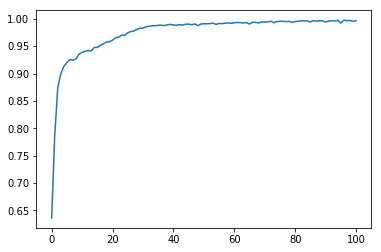

In [276]:
OVERLAP_list = np.reshape(OVERLAP_list, (np.shape(OVERLAP_list)[0]))
print len(NLL_list)
print len(epoch_list)
plt.plot(epoch_list, OVERLAP_list)
plt.show()